In [1]:
%load_ext autoreload
%autoreload 2
from modules import read_and_write
from modules import polyakov
from modules import utility
from modules import fourier_surface
from modules import surface_amplitudes as sf
from modules import global_variables
import pandas as pd
import numpy as np
import os
import glob
indices = None
surface_tension_dict = {}

For reference with integration method the following surface tensions were computed
$SU(4)$

$z_1$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.2316804724774406$

$z_2$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.5433288477348852$

$SU(6)$

$z_1$: $\alpha_{o-o} / T^3(\beta=25.5) = 5.694$

$z_2$: $\alpha_{o-o} / T^3(\beta=25.5) = 8.363$

$z_3$: $\alpha_{o-o} / T^3(\beta=25.5) = 9.199$

# Load data

In [2]:
#folders = utility.list_all_folders(global_variables.data_path_surface_abs,"su4")
folders = utility.list_all_folders(global_variables.data_path_surface_z_smear,"su4")


../data/output-measure-surface-z-smear/su4-40-40-60-6/beta-10.8-twist-1 , index: 0
../data/output-measure-surface-z-smear/su4-40-40-60-6/beta-10.8-twist-2 , index: 1
../data/output-measure-surface-z-smear/su4-60-60-80-6/beta-10.797-twist-1 , index: 2
../data/output-measure-surface-z-smear/su4-60-60-80-6/beta-10.797-twist-2 , index: 3
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-1-05-03-25 , index: 4
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-1-06-03-25 , index: 5
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-1-full , index: 6
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-1-short , index: 7
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-2-05-03-25 , index: 8
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-2-06-03-25 , index: 9
../data/output-measure-surface-z-smear/su4-80-80-120-6/beta-10.8-twist-2-full , index: 10
../data/output-measure-

In [3]:
choose_folders = [2,3]
fourier_profiles = {}

for choose_folder in choose_folders:
    folder = folders[choose_folder]
    files = glob.glob(os.path.join(folder, "fourier_profile_*"))
    for file in files:
        file_name = file.split("/")[-1]
        smearing_level = file_name.split("_")[-2] + "_" + file_name.split("_")[-1]
        volume, modes, fourier_profile = read_and_write.read_fourier_profile(folder, file_name=file_name)
        
        # Thermalise the results by dropping the first n results
        therm = 3000
        fourier_profile = fourier_profile[therm:]
        
        if smearing_level in fourier_profiles:
            fourier_profiles[smearing_level] = np.concatenate((fourier_profiles[smearing_level], fourier_profile), axis=0)
        else:
            fourier_profiles[smearing_level] = fourier_profile

fourier_profiles = dict(sorted(fourier_profiles.items(), key=lambda item: int(item[0])))
print(len(fourier_profiles[list(fourier_profiles.keys())[0]]), fourier_profiles.keys())
#utility.display_markdown_title(folder)


52446 dict_keys(['50_70', '50_80', '60_70', '60_80', '70_70', '70_80', '80_70', '80_80'])


## Perform post processing

In [37]:
f_n_list = []
errors_list = []
# Define the fixed value for y
z_smear = '80'

# Create a list of smearing levels that match the fixed y value
subset_smearing_levels = [level for level in fourier_profiles.keys() if level.split('_')[1] == z_smear]
print(subset_smearing_levels)
usable_smearing_levels = set()
for smearing_level, profile in fourier_profiles.items():
    if smearing_level in subset_smearing_levels:
        if indices is not None:
            sample_size = len(profile)
            indices_set = indices[smearing_level]
            profile = np.delete(profile, list(indices_set), axis=0)
            print(f"Dropped {sample_size-len(profile)} samples")
        f_n, errors = utility.compute_with_aa_jackknife_fourier(profile, 10, thermalization=3000)
        if np.any(np.isnan(f_n)) or np.any(np.isinf(f_n)):
            nan_indices = np.where(np.isnan(f_n))[0]
            inf_indices = np.where(np.isinf(f_n))[0]
            print(f"NaNs detected at indices {nan_indices} for smearing level {smearing_level}")
            print(f"Infs detected at indices {inf_indices} for smearing level {smearing_level}")
        else:
            usable_smearing_levels.add(smearing_level)
            f_n_list.append(f_n)
            errors_list.append(errors)



['50_80', '60_80', '70_80', '80_80']
NaNs detected at indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] for smearing level 50_80
Infs detected at indices [] for smearing level 50_80


In [38]:
print(usable_smearing_levels)

{'70_80', '60_80', '80_80'}


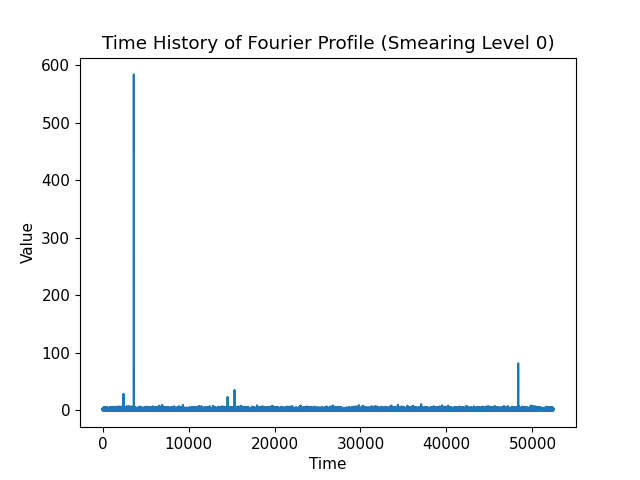

In [26]:
import matplotlib.pyplot as plt
%matplotlib widget

plt.figure()
plt.plot(fourier_profiles["50_80"][:, 3])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time History of Fourier Profile (Smearing Level 0)')
plt.show()

## Plot Fourier modes for different smearing steps

In [77]:
twist = folder.split("/")[4].split('-')[3]
twist
temp = folder.split("/")[4].split('-')[1]
temp

'10.8'

In [ ]:
%matplotlib widget
#smearing_levels = subset_smearing_levels
show_plot = True
print(folder.split("/"))
twist = folder.split("/")[4].split('-')[3]
#twist = 2
temp = folder.split("/")[4].split('-')[1]
#temp = 10.8
data = {
    "smearing": usable_smearing_levels,
    "linear": [ 
        fourier_surface.compute_fourier_profile(
            modes, f_n, volume, errors=error, beta=temp, twist=twist, fit_range=4, smearing=smear, show_plot=show_plot
        ) for f_n, error, smear in zip( f_n_list, errors_list, usable_smearing_levels)
    ]
    # "exponential": [ 
    #     fourier_surface.compute_fourier_profile_exponential_fit(
    #         modes, f_n, volume, errors=error, beta=temp, twist=twist, smearing=smear, show_plot=show_plot
    #     ) for f_n, error, smear in zip( f_n_list, errors_list, smearing_levels)
    # ]
}
print(list(data.keys()))
fit_type = list(data.keys())[1]
name = f"volume_{volume[0]}-{volume[1]}-{volume[2]}-{volume[3]}_beta_{temp}_twist_{twist}_fit_{fit_type}_zsmear_{z_smear}"
surface_tension_dict[name] = data
# df = pd.DataFrame(data)
# utility.print_df_as_markdown_fourier_modes(df,key=fit_type)
fourier_surface.save_global_figure(volume,temp,twist,fit_type,z_smear)
fourier_surface.global_fig = None

print(surface_tension_dict)

['..', 'data', 'output-measure-surface-z-smear', 'su4-60-60-80-6', 'beta-10.797-twist-2']


TypeError: 'dict_keys' object is not subscriptable

['..', 'data', 'output-measure-surface-z-smear', 'su4-80-80-120-6', 'beta-10.8-twist-1-06-03-25']


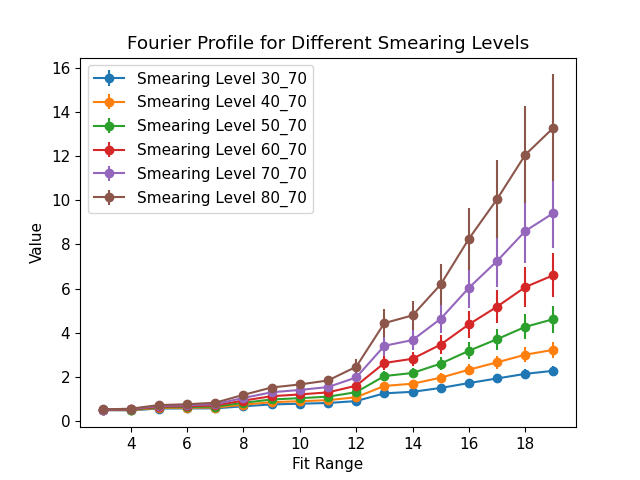

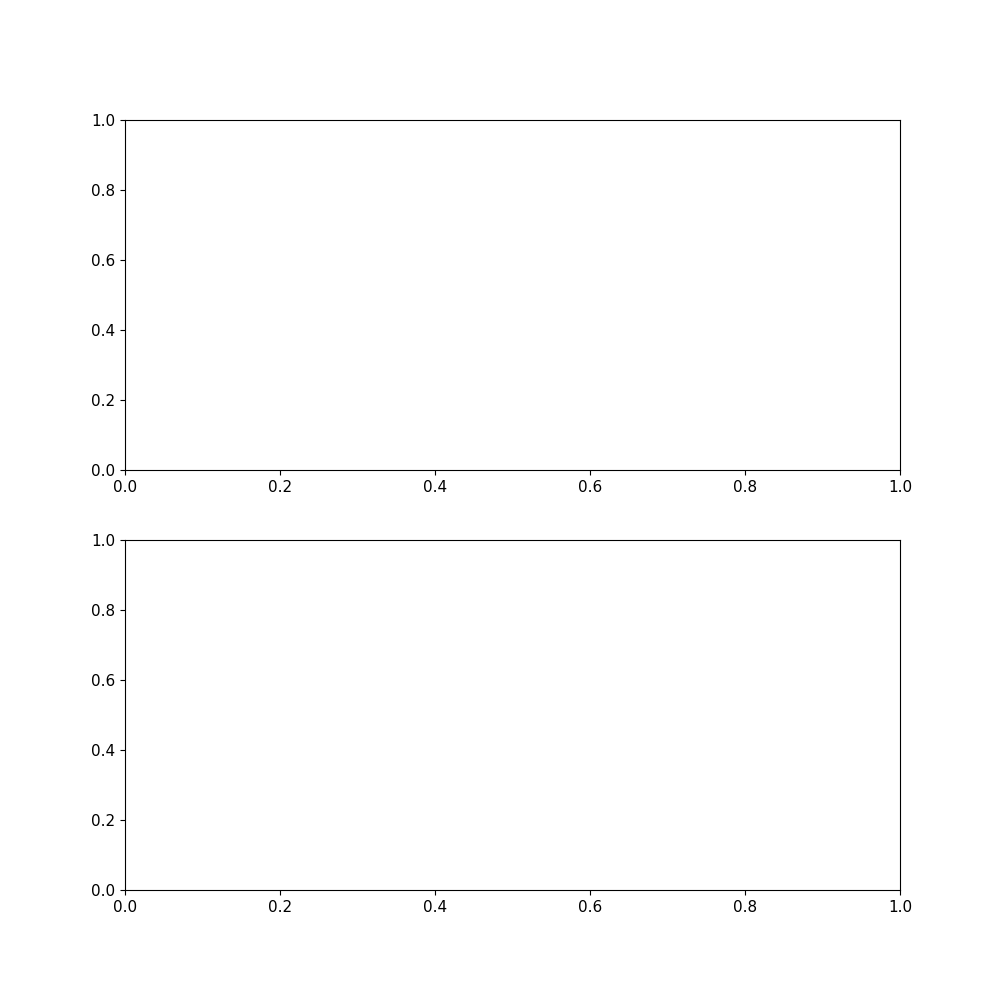

In [45]:
%matplotlib widget
import matplotlib.pyplot as plt
smearing_levels = subset_smearing_levels
show_plot = False
print(folder.split("/"))
#twist = folder.split("/")[4].split('-')[3]
twist = 0
#temp = folder.split("/")[4].split('-')[1]
temp = 10.8
df = pd.DataFrame()
for i in range(3, 20):
    data = {
        "smearing": smearing_levels,
        f"{i}": [
            fourier_surface.compute_fourier_profile(
                modes, f_n, volume, errors=error, beta=temp, twist=twist, fit_range=i, smearing=smear, show_plot=show_plot
            ) for f_n, error, smear in zip(f_n_list, errors_list, smearing_levels)
        ]
    }
    if 'df' in locals():
        df[f"{i}"] = data[f"{i}"]
    else:
        df = pd.DataFrame(data)
df.index = data["smearing"]
df
smearing_select = smearing_levels
fig, ax = plt.subplots()
for index, row in df.iterrows():
    if index not in smearing_select:
        continue
    x_values = df.columns.astype(int)
    y_values = [val[0] for val in row]
    y_errors = [val[1] for val in row]
    ax.errorbar(x_values, y_values, yerr=y_errors, fmt='-o', label=f'Smearing Level {index}')
ax.set_xlabel('Fit Range')
ax.set_ylabel('Value')
ax.set_title('Fourier Profile for Different Smearing Levels')
ax.legend()
plt.show()
#df.set_index('smearing', inplace=True)


In [ ]:
surface_tension_dict.keys()i

dict_keys(['volume_80-80-120-6_beta_10.8_twist_1_fit_exponential_zsmear_70', 'volume_80-80-120-6_beta_10.8_twist_2_fit_exponential_zsmear_70'])

In [ ]:
read_and_write.write_surface_tension_dict(surface_tension_dict,file_path="./Results/Surface_tension_smeared/beta-10.825-su4-80-80-100-6.txt")

In [70]:
surface_tension_dict

{'volume_80-80-120-6_beta_10.8_twist_1_fit_exponential_zsmear_70': {'smearing': ['30_70',
   '40_70',
   '50_70',
   '60_70',
   '70_70',
   '80_70'],
  'exponential': [(0.512758247733839, 0.0043857968958861595),
   (0.5141073875563358, 0.004517738274851946),
   (0.5153007854221324, 0.004676017448315836),
   (0.5163056654143897, 0.004841186273565042),
   (0.517072541023113, 0.00500825686423939),
   (0.5175385507759486, 0.005173045552752243)]},
 'volume_80-80-120-6_beta_10.8_twist_2_fit_exponential_zsmear_70': {'smearing': ['30_70',
   '40_70',
   '50_70',
   '60_70',
   '70_70',
   '80_70'],
  'exponential': [(0.512758247733839, 0.0043857968958861595),
   (0.5141073875563358, 0.004517738274851946),
   (0.5153007854221324, 0.004676017448315836),
   (0.5163056654143897, 0.004841186273565042),
   (0.517072541023113, 0.00500825686423939),
   (0.5175385507759486, 0.005173045552752243)]}}

In [34]:
import matplotlib.pyplot as plt

plt.close('all')